In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Flatten, TimeDistributed, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from glob import glob
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Activation, Multiply
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import Sequence

In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
from tensorflow.keras.layers import Layer, Dense, Activation, Multiply, Lambda
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch_size, timesteps, features)
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias', 
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.V = self.add_weight(name='att_var', 
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs: (batch_size, timesteps, features)
        # Score calculation for each time step
        score = K.tanh(K.dot(inputs, self.W) + self.b)  # (batch_size, timesteps, features)
        score = K.dot(score, self.V)  # (batch_size, timesteps, 1)
        attention_weights = K.softmax(score, axis=1)  # (batch_size, timesteps, 1)
        
        # Multiply each time step by its attention weight
        context_vector = inputs * attention_weights  # (batch_size, timesteps, features)
        context_vector = K.sum(context_vector, axis=1)   # (batch_size, features)
        return context_vector

# Convenience function to use the layer
def attention_layer(inputs):
    return AttentionLayer()(inputs)


In [5]:
def build_model(input_shape=(299, 299, 9)):
    """
    Builds an improved Xception-based spatial feature extractor and a Bidirectional LSTM
    for temporal analysis with pooling layers and batch normalization.
    """
    print("Building improved model...")

    # Spatial Feature Extractor
    base_model = Xception(include_top=False, weights=None, input_shape=input_shape)

    # Use GlobalAveragePooling2D to aggregate the spatial features.
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    spatial_model = Model(inputs=base_model.input, outputs=x, name="spatial_model")

    # Temporal Analysis with LSTM (Improved)
    lstm_input = Input(shape=(None, 512), name="lstm_input")

    # First LSTM remains the same:
    lstm_out = Bidirectional(LSTM(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.2))(lstm_input)
    # Change the second LSTM to output sequences (i.e., 3D tensor)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.4))(lstm_out)

    # Now attention_layer receives a 3D tensor as expected
    attn_out = attention_layer(lstm_out)
    attn_out = BatchNormalization()(attn_out)

    output = Dense(1, activation='sigmoid')(attn_out)
    temporal_model = Model(inputs=lstm_input, outputs=output, name="temporal_model")

    print("Improved model built successfully.")
    return spatial_model, temporal_model


def train_model(spatial_model, temporal_model, x_train, y_train, x_test, y_test, epochs=100, batch_size=32):
    """Trains the model with improved training strategy."""
    print("Extracting features from Xception (Spatial Model)...")

    # Extract features from Xception
    x_train_features = spatial_model.predict(x_train)
    x_test_features = spatial_model.predict(x_test)

    # Reshape for LSTM
    x_train_features = np.expand_dims(x_train_features, axis=1)
    x_test_features = np.expand_dims(x_test_features, axis=1)

    # Compile the LSTM (Temporal Model)
    temporal_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    print("Training Improved Temporal Model (LSTM)...")

    # Callbacks
    model_checkpoint = ModelCheckpoint(
        filepath="best_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        verbose=1
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

    # Train the LSTM Model
    history = temporal_model.fit(
        x_train_features, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_features, y_test),
        callbacks=[model_checkpoint, early_stopping, lr_reducer]
    )

    print("Training completed.")

    # Predict on test set
    y_pred = temporal_model.predict(x_test_features)

    # Evaluate model
    plot_metrics(history, y_test, y_pred)


def plot_metrics(history, y_test, y_pred):
    """Plots training metrics, evaluation metrics, ROC curve, and precision-recall curve."""
    # Training Loss and Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Compute Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    
    # Plot Precision-Recall Curve
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # Print evaluation metrics
    y_pred_binary = (y_pred > 0.5).astype(int)
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred_binary):.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    print(f'Recall Score: {recall_score(y_test, y_pred_binary):.4f}')
    print(f'Precision Score: {precision_score(y_test, y_pred_binary):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred_binary):.4f}')
    print(f'PR AUC Score: {pr_auc:.4f}')
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary))

In [6]:
# # Load precomputed dataset
# save_path = "E:/dataset_1/preprocessed_happy.npz"
# print(f"📂 Loading precomputed dataset from {save_path}...")
# data = np.load(save_path)

# # Extract x_data and y_data
# x_data, y_data = data["x"], data["y"]
# print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# # Train-test split
# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# # Verify shapes
# print(f"📊 Train/Test Split:")
# print(f"  x_train: {x_train.shape}, y_train: {y_train.shape}")
# print(f"  x_test: {x_test.shape}, y_test: {y_test.shape}")

In [7]:



# Create a Sequence wrapper to load batches from the memmap on demand.
class MemmapSequence(Sequence):
    def __init__(self, memmap_array, indices, batch_size=32):
        self.memmap_array = memmap_array
        self.indices = indices
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        # When using fancy indexing on a memmap, a copy is made only for this batch.
        return self.memmap_array[batch_idx]

# --- Data Loading Without Loading Entire Dataset Into RAM ---

# Load the dataset with memory mapping so that the full array isn’t loaded into RAM immediately.
save_path = "E:/dataset_1/preprocessed_surprise.npz"
print(f"📂 Loading precomputed dataset from {save_path}...")
data = np.load(save_path, mmap_mode='r')  # memmap; data remains on disk until accessed
x_data, y_data = data["x"], data["y"]
print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# Use StratifiedShuffleSplit to get train/test indices without forcing a full copy.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(x_data, y_data))

# Sorting indices can help get more contiguous slices.
train_idx = np.sort(train_idx)
test_idx = np.sort(test_idx)

# Instead of slicing x_data (which would copy a 12GB block into memory),
# create Sequences that load data in batches.
batch_size = 32
x_train_seq = MemmapSequence(x_data, train_idx, batch_size=batch_size)
x_test_seq = MemmapSequence(x_data, test_idx, batch_size=batch_size)

# y_data is small so we load it normally.
y_train = y_data[train_idx]
y_test = y_data[test_idx]

print("📊 Train/Test Split:")
print(f"  x_train_seq: {len(x_train_seq)} batches (batch_size={batch_size}), y_train: {y_train.shape}")
print(f"  x_test_seq: {len(x_test_seq)} batches (batch_size={batch_size}), y_test: {y_test.shape}")

# --- Training the Model ---
# Now call your train_model function as before—but pass the Sequence objects instead of full numpy arrays.
# For example:
#
# spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))
# train_model(spatial_model, temporal_model, x_train_seq, y_train, x_test_seq, y_test)
#
# Keras model.predict (and model.fit, if needed) supports Sequence objects, so your existing
# build_model() and train_model() functions remain unchanged.


📂 Loading precomputed dataset from E:/dataset_1/preprocessed_surprise.npz...
✅ Loaded dataset: 20000 samples.
📊 Train/Test Split:
  x_train_seq: 500 batches (batch_size=32), y_train: (16000,)
  x_test_seq: 125 batches (batch_size=32), y_test: (4000,)


In [8]:
# if __name__ == "__main__":
#     real_faces = "E:/Research/real/Cropped_Faces"
#     fake_faces = "E:/Research/fake/Cropped_Faces"
    # real_data, fake_data = prepare_data(real_faces, "", fake_faces, "")
    
    # Build the Spatial and Temporal Models
spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# y_test = y_test.astype('float32')
# y_test = y_test.astype('float32')

# spatial_model.summary()
temporal_model.summary()


Building improved model...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\applications\xception.py:111: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 9 input channels.
  input_shape = imagenet_utils.obtain_input_shape(



Improved model built successfully.


Model: "temporal_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 512)      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 256)      │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 256)            │        66,048 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,298,625 (8.77 MB)

 Trainable params: 2,298,113 (8.77 MB)

 Non-trainable params: 512 (2.00 KB)

Extracting features from Xception (Spatial Model)...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 2046s 4s/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 512s 4s/step
Training Improved Temporal Model (LSTM)...
Epoch 1/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5171 - loss: 0.6929
Epoch 1: val_accuracy improved from -inf to 0.60850, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.5172 - loss: 0.6929 - val_accuracy: 0.6085 - val_loss: 0.6921 - learning_rate: 1.0000e-04
Epoch 2/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6657 - loss: 0.6861
Epoch 2: val_accuracy did not improve from 0.60850
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.6659 - loss: 0.6860 - val_accuracy: 0.5000 - val_loss: 0.6595 - learning_rate: 1.0000e-04
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7789 - loss: 0.6122
Epoch 3: val_accuracy did not improve from 0.60850
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.7790 - loss: 0.6121 - val_accuracy: 0.5000 - val_loss: 1.3225 - learning_rate: 1.0000e-04
Epoch 4/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8450 - loss: 0.4310
Epoch 4: val_accuracy improved from 0.60850 to 0.64875, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8450 - loss: 0.4308 - val_accuracy: 0.6488 - val_loss: 0.5828 - learning_rate: 1.0000e-04
Epoch 5/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8670 - loss: 0.3322
Epoch 5: val_accuracy improved from 0.64875 to 0.78875, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8670 - loss: 0.3322 - val_accuracy: 0.7887 - val_loss: 0.4187 - learning_rate: 1.0000e-04
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8675 - loss: 0.3226
Epoch 6: val_accuracy improved from 0.78875 to 0.87900, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8675 - loss: 0.3226 - val_accuracy: 0.8790 - val_loss: 0.2858 - learning_rate: 1.0000e-04
Epoch 7/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8687 - loss: 0.3109
Epoch 7: val_accuracy did not improve from 0.87900
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8686 - loss: 0.3109 - val_accuracy: 0.8775 - val_loss: 0.2842 - learning_rate: 1.0000e-04
Epoch 8/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8709 - loss: 0.3054
Epoch 8: val_accuracy improved from 0.87900 to 0.88825, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8709 - loss: 0.3054 - val_accuracy: 0.8882 - val_loss: 0.2731 - learning_rate: 1.0000e-04
Epoch 9/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8671 - loss: 0.3119
Epoch 9: val_accuracy did not improve from 0.88825
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8671 - loss: 0.3119 - val_accuracy: 0.8878 - val_loss: 0.2708 - learning_rate: 1.0000e-04
Epoch 10/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8687 - loss: 0.3128
Epoch 10: val_accuracy did not improve from 0.88825
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8687 - loss: 0.3128 - val_accuracy: 0.8725 - val_loss: 0.2982 - learning_rate: 1.0000e-04
Epoch 11/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8742 - loss: 0.2968
Epoch 11: val_accuracy did not improve from 0.88825
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8742 - loss: 0.2968 - val_accuracy: 0.8870 - val_loss: 0.2679 - learning_rate: 1.

500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8707 - loss: 0.3051 - val_accuracy: 0.8907 - val_loss: 0.2667 - learning_rate: 1.0000e-04
Epoch 13/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8753 - loss: 0.3071
Epoch 13: val_accuracy did not improve from 0.89075
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8753 - loss: 0.3071 - val_accuracy: 0.8848 - val_loss: 0.2688 - learning_rate: 1.0000e-04
Epoch 14/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8705 - loss: 0.3130
Epoch 14: val_accuracy did not improve from 0.89075
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8706 - loss: 0.3130 - val_accuracy: 0.8758 - val_loss: 0.3137 - learning_rate: 1.0000e-04
Epoch 15/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8756 - loss: 0.3073
Epoch 15: val_accuracy improved from 0.89075 to 0.89225, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8755 - loss: 0.3073 - val_accuracy: 0.8923 - val_loss: 0.2627 - learning_rate: 1.0000e-04
Epoch 16/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8765 - loss: 0.3011
Epoch 16: val_accuracy improved from 0.89225 to 0.89375, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8765 - loss: 0.3011 - val_accuracy: 0.8938 - val_loss: 0.2616 - learning_rate: 1.0000e-04
Epoch 17/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8770 - loss: 0.2946
Epoch 17: val_accuracy did not improve from 0.89375
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8770 - loss: 0.2946 - val_accuracy: 0.8842 - val_loss: 0.2750 - learning_rate: 1.0000e-04
Epoch 18/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8755 - loss: 0.2978
Epoch 18: val_accuracy did not improve from 0.89375
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8755 - loss: 0.2978 - val_accuracy: 0.8878 - val_loss: 0.2673 - learning_rate: 1.0000e-04
Epoch 19/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8746 - loss: 0.2928
Epoch 19: val_accuracy did not improve from 0.89375
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8746 - loss: 0.2928 - val_accuracy: 0.8892 - val_loss: 0.2597 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8731 - loss: 0.3123 - val_accuracy: 0.8953 - val_loss: 0.2551 - learning_rate: 1.0000e-04
Epoch 23/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8723 - loss: 0.3018
Epoch 23: val_accuracy did not improve from 0.89525
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8723 - loss: 0.3018 - val_accuracy: 0.8910 - val_loss: 0.2554 - learning_rate: 1.0000e-04
Epoch 24/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8818 - loss: 0.2853
Epoch 24: val_accuracy did not improve from 0.89525
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8818 - loss: 0.2854 - val_accuracy: 0.8915 - val_loss: 0.2534 - learning_rate: 1.0000e-04
Epoch 25/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8810 - loss: 0.2858
Epoch 25: val_accuracy did not improve from 0.89525
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8810 - loss: 0.2858 - val_accuracy: 0.8910 - val_loss: 0.2597 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8874 - loss: 0.2817 - val_accuracy: 0.8975 - val_loss: 0.2494 - learning_rate: 1.0000e-04
Epoch 27/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8800 - loss: 0.2895
Epoch 27: val_accuracy improved from 0.89750 to 0.89800, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8800 - loss: 0.2895 - val_accuracy: 0.8980 - val_loss: 0.2472 - learning_rate: 1.0000e-04
Epoch 28/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8812 - loss: 0.2911
Epoch 28: val_accuracy did not improve from 0.89800
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8812 - loss: 0.2911 - val_accuracy: 0.8947 - val_loss: 0.2473 - learning_rate: 1.0000e-04
Epoch 29/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8789 - loss: 0.2868
Epoch 29: val_accuracy improved from 0.89800 to 0.89975, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8790 - loss: 0.2868 - val_accuracy: 0.8997 - val_loss: 0.2450 - learning_rate: 1.0000e-04
Epoch 30/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8870 - loss: 0.2805
Epoch 30: val_accuracy improved from 0.89975 to 0.90000, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.8870 - loss: 0.2805 - val_accuracy: 0.9000 - val_loss: 0.2437 - learning_rate: 1.0000e-04
Epoch 31/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8827 - loss: 0.2868
Epoch 31: val_accuracy improved from 0.90000 to 0.90225, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.8827 - loss: 0.2868 - val_accuracy: 0.9022 - val_loss: 0.2417 - learning_rate: 1.0000e-04
Epoch 32/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8860 - loss: 0.2828
Epoch 32: val_accuracy improved from 0.90225 to 0.90375, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8860 - loss: 0.2828 - val_accuracy: 0.9038 - val_loss: 0.2405 - learning_rate: 1.0000e-04
Epoch 33/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8826 - loss: 0.2828
Epoch 33: val_accuracy did not improve from 0.90375
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8826 - loss: 0.2828 - val_accuracy: 0.9022 - val_loss: 0.2433 - learning_rate: 1.0000e-04
Epoch 34/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8846 - loss: 0.2905
Epoch 34: val_accuracy did not improve from 0.90375
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8846 - loss: 0.2905 - val_accuracy: 0.9007 - val_loss: 0.2425 - learning_rate: 1.0000e-04
Epoch 35/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8852 - loss: 0.2811
Epoch 35: val_accuracy did not improve from 0.90375
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8852 - loss: 0.2811 - val_accuracy: 0.9025 - val_loss: 0.2486 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8867 - loss: 0.2758 - val_accuracy: 0.9072 - val_loss: 0.2335 - learning_rate: 5.0000e-05
Epoch 38/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8900 - loss: 0.2695
Epoch 38: val_accuracy did not improve from 0.90725
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8900 - loss: 0.2695 - val_accuracy: 0.9030 - val_loss: 0.2348 - learning_rate: 5.0000e-05
Epoch 39/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8957 - loss: 0.2650
Epoch 39: val_accuracy did not improve from 0.90725
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8956 - loss: 0.2651 - val_accuracy: 0.9068 - val_loss: 0.2345 - learning_rate: 5.0000e-05
Epoch 40/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8863 - loss: 0.2822
Epoch 40: val_accuracy improved from 0.90725 to 0.90775, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8863 - loss: 0.2821 - val_accuracy: 0.9078 - val_loss: 0.2343 - learning_rate: 5.0000e-05
Epoch 41/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8917 - loss: 0.2816
Epoch 41: val_accuracy improved from 0.90775 to 0.90825, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8918 - loss: 0.2815 - val_accuracy: 0.9082 - val_loss: 0.2296 - learning_rate: 5.0000e-05
Epoch 42/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8924 - loss: 0.2657
Epoch 42: val_accuracy did not improve from 0.90825
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8924 - loss: 0.2657 - val_accuracy: 0.9030 - val_loss: 0.2401 - learning_rate: 5.0000e-05
Epoch 43/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8909 - loss: 0.2799
Epoch 43: val_accuracy did not improve from 0.90825
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8909 - loss: 0.2798 - val_accuracy: 0.9047 - val_loss: 0.2306 - learning_rate: 5.0000e-05
Epoch 44/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8923 - loss: 0.2634
Epoch 44: val_accuracy improved from 0.90825 to 0.90900, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8923 - loss: 0.2634 - val_accuracy: 0.9090 - val_loss: 0.2278 - learning_rate: 5.0000e-05
Epoch 45/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8930 - loss: 0.2628
Epoch 45: val_accuracy improved from 0.90900 to 0.90925, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8930 - loss: 0.2628 - val_accuracy: 0.9093 - val_loss: 0.2269 - learning_rate: 5.0000e-05
Epoch 46/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8947 - loss: 0.2664
Epoch 46: val_accuracy improved from 0.90925 to 0.91050, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8947 - loss: 0.2664 - val_accuracy: 0.9105 - val_loss: 0.2287 - learning_rate: 5.0000e-05
Epoch 47/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8923 - loss: 0.2734
Epoch 47: val_accuracy did not improve from 0.91050
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8923 - loss: 0.2734 - val_accuracy: 0.9105 - val_loss: 0.2263 - learning_rate: 5.0000e-05
Epoch 48/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8917 - loss: 0.2741
Epoch 48: val_accuracy improved from 0.91050 to 0.91125, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8917 - loss: 0.2741 - val_accuracy: 0.9112 - val_loss: 0.2274 - learning_rate: 5.0000e-05
Epoch 49/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8952 - loss: 0.2569
Epoch 49: val_accuracy improved from 0.91125 to 0.91175, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8952 - loss: 0.2569 - val_accuracy: 0.9118 - val_loss: 0.2266 - learning_rate: 5.0000e-05
Epoch 50/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8919 - loss: 0.2606
Epoch 50: val_accuracy improved from 0.91175 to 0.91225, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8919 - loss: 0.2606 - val_accuracy: 0.9122 - val_loss: 0.2240 - learning_rate: 5.0000e-05
Epoch 51/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8928 - loss: 0.2688
Epoch 51: val_accuracy did not improve from 0.91225
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8928 - loss: 0.2688 - val_accuracy: 0.9055 - val_loss: 0.2321 - learning_rate: 5.0000e-05
Epoch 52/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8974 - loss: 0.2580
Epoch 52: val_accuracy improved from 0.91225 to 0.91450, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8974 - loss: 0.2580 - val_accuracy: 0.9145 - val_loss: 0.2224 - learning_rate: 5.0000e-05
Epoch 53/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8937 - loss: 0.2685
Epoch 53: val_accuracy improved from 0.91450 to 0.91500, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8937 - loss: 0.2685 - val_accuracy: 0.9150 - val_loss: 0.2220 - learning_rate: 5.0000e-05
Epoch 54/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8998 - loss: 0.2578
Epoch 54: val_accuracy improved from 0.91500 to 0.91525, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8998 - loss: 0.2579 - val_accuracy: 0.9153 - val_loss: 0.2182 - learning_rate: 5.0000e-05
Epoch 55/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8964 - loss: 0.2628
Epoch 55: val_accuracy did not improve from 0.91525
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8964 - loss: 0.2628 - val_accuracy: 0.9145 - val_loss: 0.2210 - learning_rate: 5.0000e-05
Epoch 56/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8988 - loss: 0.2535
Epoch 56: val_accuracy improved from 0.91525 to 0.91575, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8987 - loss: 0.2535 - val_accuracy: 0.9158 - val_loss: 0.2177 - learning_rate: 5.0000e-05
Epoch 57/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8918 - loss: 0.2625
Epoch 57: val_accuracy did not improve from 0.91575
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8919 - loss: 0.2625 - val_accuracy: 0.9095 - val_loss: 0.2232 - learning_rate: 5.0000e-05
Epoch 58/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8971 - loss: 0.2608
Epoch 58: val_accuracy improved from 0.91575 to 0.91700, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8971 - loss: 0.2608 - val_accuracy: 0.9170 - val_loss: 0.2168 - learning_rate: 5.0000e-05
Epoch 59/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8966 - loss: 0.2585
Epoch 59: val_accuracy did not improve from 0.91700
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8966 - loss: 0.2585 - val_accuracy: 0.9170 - val_loss: 0.2134 - learning_rate: 5.0000e-05
Epoch 60/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9038 - loss: 0.2517
Epoch 60: val_accuracy improved from 0.91700 to 0.92075, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9038 - loss: 0.2517 - val_accuracy: 0.9208 - val_loss: 0.2146 - learning_rate: 5.0000e-05
Epoch 61/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9006 - loss: 0.2552
Epoch 61: val_accuracy improved from 0.92075 to 0.92225, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9006 - loss: 0.2552 - val_accuracy: 0.9222 - val_loss: 0.2134 - learning_rate: 5.0000e-05
Epoch 62/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9050 - loss: 0.2488
Epoch 62: val_accuracy did not improve from 0.92225
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9050 - loss: 0.2488 - val_accuracy: 0.9122 - val_loss: 0.2171 - learning_rate: 5.0000e-05
Epoch 63/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9047 - loss: 0.2539
Epoch 63: val_accuracy did not improve from 0.92225
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9047 - loss: 0.2539 - val_accuracy: 0.9215 - val_loss: 0.2111 - learning_rate: 5.0000e-05
Epoch 64/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9028 - loss: 0.2490
Epoch 64: val_accuracy did not improve from 0.92225
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9028 - loss: 0.2490 - val_accuracy: 0.9195 - val_loss: 0.2116 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8996 - loss: 0.2465 - val_accuracy: 0.9243 - val_loss: 0.2059 - learning_rate: 5.0000e-05
Epoch 69/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8996 - loss: 0.2491
Epoch 69: val_accuracy did not improve from 0.92425
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8996 - loss: 0.2491 - val_accuracy: 0.9225 - val_loss: 0.2054 - learning_rate: 5.0000e-05
Epoch 70/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9022 - loss: 0.2459
Epoch 70: val_accuracy improved from 0.92425 to 0.92675, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9022 - loss: 0.2459 - val_accuracy: 0.9268 - val_loss: 0.2041 - learning_rate: 5.0000e-05
Epoch 71/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9039 - loss: 0.2390
Epoch 71: val_accuracy did not improve from 0.92675
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9039 - loss: 0.2390 - val_accuracy: 0.9237 - val_loss: 0.2046 - learning_rate: 5.0000e-05
Epoch 72/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9074 - loss: 0.2324
Epoch 72: val_accuracy did not improve from 0.92675
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9074 - loss: 0.2324 - val_accuracy: 0.9225 - val_loss: 0.2046 - learning_rate: 5.0000e-05
Epoch 73/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9056 - loss: 0.2453
Epoch 73: val_accuracy improved from 0.92675 to 0.92825, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9056 - loss: 0.2453 - val_accuracy: 0.9283 - val_loss: 0.2005 - learning_rate: 5.0000e-05
Epoch 74/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9027 - loss: 0.2533
Epoch 74: val_accuracy did not improve from 0.92825
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9027 - loss: 0.2533 - val_accuracy: 0.9222 - val_loss: 0.2057 - learning_rate: 5.0000e-05
Epoch 75/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9108 - loss: 0.2337
Epoch 75: val_accuracy improved from 0.92825 to 0.93000, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9108 - loss: 0.2337 - val_accuracy: 0.9300 - val_loss: 0.1980 - learning_rate: 5.0000e-05
Epoch 76/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9097 - loss: 0.2387
Epoch 76: val_accuracy did not improve from 0.93000
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9097 - loss: 0.2387 - val_accuracy: 0.9287 - val_loss: 0.1977 - learning_rate: 5.0000e-05
Epoch 77/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9009 - loss: 0.2575
Epoch 77: val_accuracy improved from 0.93000 to 0.93075, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9010 - loss: 0.2575 - val_accuracy: 0.9308 - val_loss: 0.1956 - learning_rate: 5.0000e-05
Epoch 78/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9053 - loss: 0.2542
Epoch 78: val_accuracy did not improve from 0.93075
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9053 - loss: 0.2541 - val_accuracy: 0.9222 - val_loss: 0.2012 - learning_rate: 5.0000e-05
Epoch 79/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9059 - loss: 0.2399
Epoch 79: val_accuracy improved from 0.93075 to 0.93200, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9059 - loss: 0.2399 - val_accuracy: 0.9320 - val_loss: 0.1933 - learning_rate: 5.0000e-05
Epoch 80/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9120 - loss: 0.2371
Epoch 80: val_accuracy did not improve from 0.93200
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9120 - loss: 0.2371 - val_accuracy: 0.9252 - val_loss: 0.2021 - learning_rate: 5.0000e-05
Epoch 81/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9057 - loss: 0.2405
Epoch 81: val_accuracy improved from 0.93200 to 0.93350, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9057 - loss: 0.2405 - val_accuracy: 0.9335 - val_loss: 0.1915 - learning_rate: 5.0000e-05
Epoch 82/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9094 - loss: 0.2373
Epoch 82: val_accuracy did not improve from 0.93350
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9094 - loss: 0.2373 - val_accuracy: 0.9245 - val_loss: 0.2010 - learning_rate: 5.0000e-05
Epoch 83/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9122 - loss: 0.2282
Epoch 83: val_accuracy did not improve from 0.93350
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9122 - loss: 0.2282 - val_accuracy: 0.9298 - val_loss: 0.1950 - learning_rate: 5.0000e-05
Epoch 84/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9095 - loss: 0.2358
Epoch 84: val_accuracy improved from 0.93350 to 0.93525, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9095 - loss: 0.2358 - val_accuracy: 0.9352 - val_loss: 0.1877 - learning_rate: 5.0000e-05
Epoch 85/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9111 - loss: 0.2326
Epoch 85: val_accuracy did not improve from 0.93525
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9111 - loss: 0.2326 - val_accuracy: 0.9342 - val_loss: 0.1873 - learning_rate: 5.0000e-05
Epoch 86/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9080 - loss: 0.2408
Epoch 86: val_accuracy improved from 0.93525 to 0.93575, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9080 - loss: 0.2408 - val_accuracy: 0.9358 - val_loss: 0.1862 - learning_rate: 5.0000e-05
Epoch 87/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9131 - loss: 0.2337
Epoch 87: val_accuracy did not improve from 0.93575
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9131 - loss: 0.2337 - val_accuracy: 0.9275 - val_loss: 0.1939 - learning_rate: 5.0000e-05
Epoch 88/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9137 - loss: 0.2223
Epoch 88: val_accuracy did not improve from 0.93575
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9137 - loss: 0.2223 - val_accuracy: 0.9323 - val_loss: 0.1879 - learning_rate: 5.0000e-05
Epoch 89/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9078 - loss: 0.2371
Epoch 89: val_accuracy did not improve from 0.93575
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9078 - loss: 0.2370 - val_accuracy: 0.9335 - val_loss: 0.1906 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9113 - loss: 0.2283 - val_accuracy: 0.9383 - val_loss: 0.1806 - learning_rate: 5.0000e-05
Epoch 91/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9117 - loss: 0.2315
Epoch 91: val_accuracy did not improve from 0.93825
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9117 - loss: 0.2315 - val_accuracy: 0.9330 - val_loss: 0.1842 - learning_rate: 5.0000e-05
Epoch 92/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9149 - loss: 0.2243
Epoch 92: val_accuracy did not improve from 0.93825
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9149 - loss: 0.2243 - val_accuracy: 0.9308 - val_loss: 0.1879 - learning_rate: 5.0000e-05
Epoch 93/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9186 - loss: 0.2243
Epoch 93: val_accuracy did not improve from 0.93825
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9186 - loss: 0.2243 - val_accuracy: 0.9355 - val_loss: 0.1852 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9141 - loss: 0.2283 - val_accuracy: 0.9390 - val_loss: 0.1774 - learning_rate: 5.0000e-05
Epoch 95/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9100 - loss: 0.2347
Epoch 95: val_accuracy did not improve from 0.93900
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9100 - loss: 0.2347 - val_accuracy: 0.9367 - val_loss: 0.1820 - learning_rate: 5.0000e-05
Epoch 96/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9169 - loss: 0.2231
Epoch 96: val_accuracy improved from 0.93900 to 0.94075, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9168 - loss: 0.2231 - val_accuracy: 0.9408 - val_loss: 0.1755 - learning_rate: 5.0000e-05
Epoch 97/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9154 - loss: 0.2334
Epoch 97: val_accuracy improved from 0.94075 to 0.94150, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9154 - loss: 0.2333 - val_accuracy: 0.9415 - val_loss: 0.1752 - learning_rate: 5.0000e-05
Epoch 98/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9151 - loss: 0.2189
Epoch 98: val_accuracy did not improve from 0.94150
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9151 - loss: 0.2189 - val_accuracy: 0.9400 - val_loss: 0.1750 - learning_rate: 5.0000e-05
Epoch 99/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9187 - loss: 0.2191
Epoch 99: val_accuracy did not improve from 0.94150
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9187 - loss: 0.2191 - val_accuracy: 0.9410 - val_loss: 0.1749 - learning_rate: 5.0000e-05
Epoch 100/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9190 - loss: 0.2211
Epoch 100: val_accuracy did not improve from 0.94150
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9190 - loss: 0.2211 - val_accuracy: 0.9358 - val_loss: 0.1784 - learning_rate

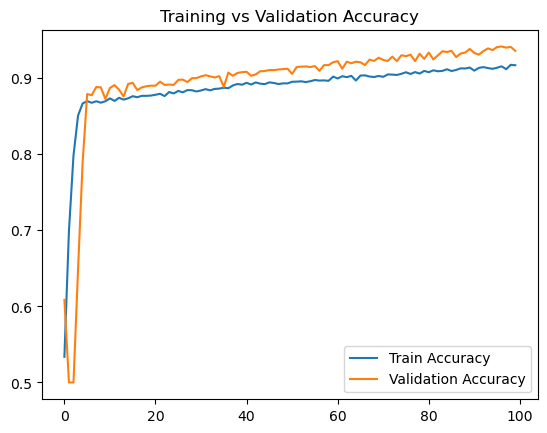

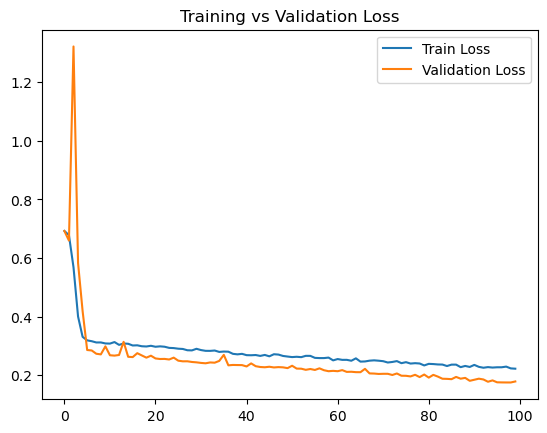

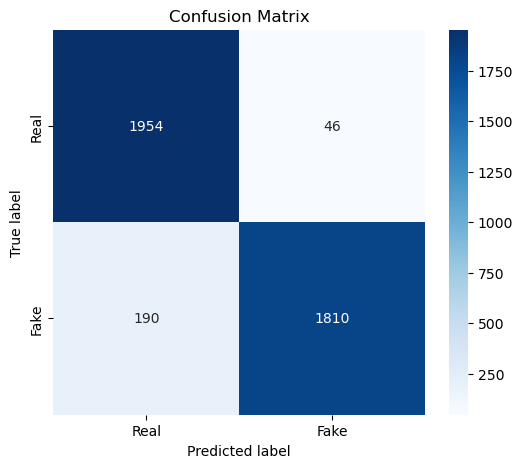

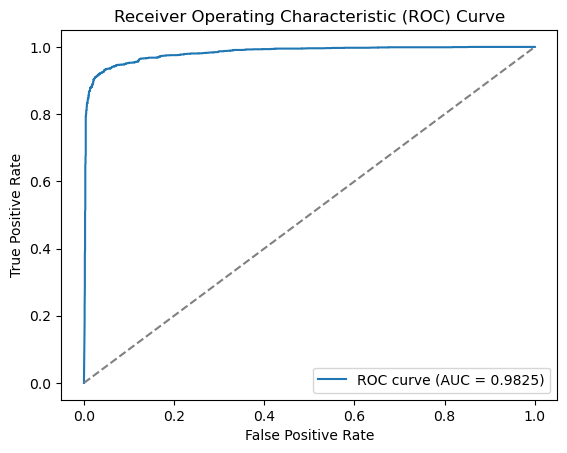

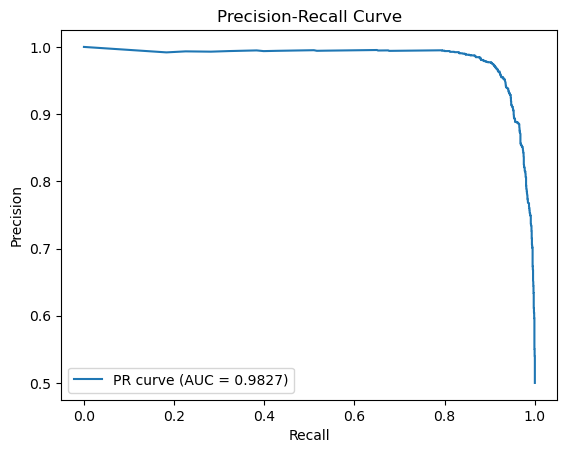

Accuracy Score: 0.9410
ROC AUC Score: 0.9825
Recall Score: 0.9050
Precision Score: 0.9752
F1 Score: 0.9388
PR AUC Score: 0.9827
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2000
           1       0.98      0.91      0.94      2000

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



In [9]:
# Train the Model
train_model(spatial_model, temporal_model, x_train_seq, y_train, x_test_seq, y_test, epochs=100, batch_size=32)